In [1]:
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
from scipy.stats import permutation_test
import torch as tc
import torch.nn as nn
import tcellmatch.api as tm

# Load Model

In [2]:
saved_model_path = '../tutorial_data/20230811-151019.saved_model'
ffn = tm.models.EstimatorFfn()
ffn.load_model_full(fn=saved_model_path, load_train_data=False)

device = 'cuda' if tc.cuda.is_available() else 'cpu'
# device='cpu'
ffn.model = ffn.model.to(device) 
for param in ffn.model.parameters():
    param = param.to(device) 

In [3]:
ffn.predict()

# Define helpers
## and hyperparameters

In [4]:
N_SAMPLES = 10
length_param = np.median(np.abs(ffn.y_test[:, None] - ffn.y_test[None, :])) + 1e-6

In [5]:
# calculate reference vars for second term, (ε_i | ε_j)_k
def k(y, y_):
    # take sigma squared to be y
    return tc.exp(-1/(2 * length_param) * (tc.log(y + 1) - tc.log(y_ + 1)) ** 2)
def c(lmd1, lmd2):
    # a and b are lambda values
    delta_E = lmd1 - lmd2
    delta_sd = tc.sqrt(lmd1) - tc.sqrt(lmd2)
    return tc.exp(-1/(2 * length_param ** 2) * (delta_E ** 2 + delta_sd ** 2))

## Define MMD function
$\sum_{i}\sum_j c(\mu(X_i),\mu(X_j))(\mu(X_i)-y_i|\mu(X_j)-y_j)_k$

In [6]:
def mmd_pois(y_hat_mtx, y_mtx):
    assert len(y_hat_mtx.shape) == len(y_mtx.shape) == 2, f'Input arrays must be two-dimensional, but found shapes {y_hat_mtx.shape} and {y_mtx.shape}'
    y_hat_mtx, y_mtx = tc.Tensor(y_hat_mtx).to(device), tc.Tensor(y_mtx).to(device)
    n, n_antigens = y_hat_mtx.shape
    n = min(N_SAMPLES, n)
    samples_idx = tc.randperm(y_hat_mtx.size(0))[:N_SAMPLES]
    y_hat_mtx, y_mtx = y_hat_mtx[samples_idx], y_mtx[samples_idx]
    # acct for log lmd
    y_hat_mtx = tc.exp(y_hat_mtx)
    

    out = tc.zeros(n_antigens, device=device)

    # 3) Look at each antigen
    for col in range(n_antigens):
        # 1) compute matrix for each value of C term
        y, y_hat = y_mtx[:, col], y_hat_mtx[:, col]
        C = c(y_hat[:, None], y_hat[None, :]) # shape n x n, C_{ij} = C(mu(X_i), mu(X_j))
        # 2) Compute matrix for the expected value over BOTH inputs to the kernel, E k(y, y')
        # create matrix of samples:
        # samples_one_{ij} = jth sample from Pois(y_hat_i)
        s = 1000
        samples_one = tc.poisson(y_hat[:, None].expand(n, s)) # shape n x s
        samples_two = tc.poisson(y_hat[:, None].expand(n, s))

        # Reshape for broadcasting
        samples_a = samples_one[:, None, :, None] 
        samples_b = samples_two[None, :, None, :]
        # Compute k for each combination of draws
        # - call this matrix B for EV over BOTH inputs
        B = k(samples_a, samples_b) # shape n x n x s x s
        
        # 3) Compute E k(y, y_i)
        # reshape y for broadcasting
        y_reshaped = y[:, None, None]
        samples_three = tc.poisson(y_hat[:, None].expand(n, s)).unsqueeze(0)
        # # compute k for each combination
        M = k(y_reshaped, samples_three) # shape n x n x s
        # 4) Compute the eNd term, N_{ij} = k(y_i, y_j)
        N = k(y_hat[:, None], y_hat[None, :]) # shape n x n
        
        # 5) Put it all together
        # we want all mcs to be of shape n x n
        # take average over samples        
        B = B.mean(dim=(-2, -1))
        M = M.mean(dim=-1)
        K = B - 2 * M + N
        ans = (C * K).mean()
        out[col] = ans
        tc.cuda.empty_cache()
        del B
        del M
        del N
        del C
        del K
    return out

In [7]:
y_hat_mtx, y_mtx = ffn.predictions, ffn.y_test + 1
out = mmd_pois(y_hat_mtx, y_mtx)

Text(0, 0.5, 'Frequency')

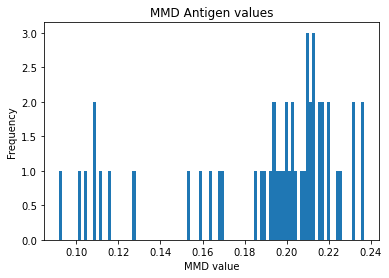

In [8]:
plt.hist(out.cpu(), bins=100)
plt.title(f"MMD Antigen values")
plt.xlabel("MMD value")
plt.ylabel("Frequency")

# Calculate $p$-value

In [9]:
p_lmd = tc.nn.PoissonNLLLoss(log_input=True, full=True, reduction='none')
# pred, obs
p = p_lmd(tc.Tensor(y_hat_mtx), tc.Tensor(y_mtx)).mean(dim=0)

Text(0, 0.5, 'Frequency')

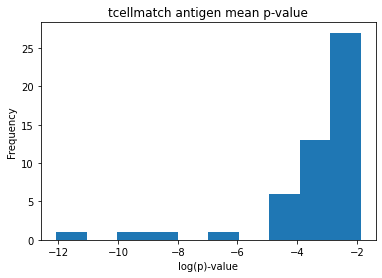

In [10]:
plt.hist(-p)
# TODO -> check the p-
plt.title(f"tcellmatch antigen mean p-value")
plt.xlabel("log(p)-value")
plt.ylabel("Frequency")

# Plot the Witness Function

In [11]:
def f(mu, y):
    mu, y = tc.Tensor(np.exp(mu)).to(device), tc.Tensor(y).to(device)
    # c_term_{ij} = c(mu_i, mu_j)
    # plt.hist(tc.exp(mu).cpu(), bins=100, log=True)
    # plt.show()
    c_term = c(mu[:, None], mu[None, :])
    n_samples = 100
    # make broadcastable and sample n x s samples
    samples = tc.poisson(mu.unsqueeze(1).expand(-1, n_samples)).to(device)
    # k_expectation_{ijk} = k(y_i, kth sample from Pois(mu_j))
    k_expectation = k(y[:, None, None], samples[None, :, :]) # shape n x n x s
    # k_pairs_{ij} = k(E[mu_i], y_j)
    k_pairs = k(mu[:, None], y[None, :]) # shape n x n
    # take expectation over mu samples
    k_term = k_pairs - k_expectation.mean(dim=2)
    # sum over all datapoints
    k_term = (k_pairs - k_term).sum(dim=1)
    out = k_term * c_term.sum(1)
    return out

In [12]:
from scipy.interpolate import griddata
def plot_witness_surface(col, n_samples=sys.maxsize):
    Z = f(y_hat_mtx[:n_samples, col], y_mtx[:n_samples, col])
    # plt.hist(Z[:n_samples].cpu(), bins=100, log=True)
    X = y_mtx[:n_samples, col]
    Y = y_hat_mtx[:n_samples, col]

    graph = np.column_stack((X, np.exp(Y), Z.cpu()))
    sorted_idcs = np.lexsort((graph[:,2], graph[:,1]))
    graph = graph[sorted_idcs]
    # graph = graph[graph[:, 0] < 10]

    x_range = np.linspace(min(graph[:, 0]), max(graph[:, 0]), 100)
    y_range = np.linspace(min(graph[:, 1]), max(graph[:, 1]), 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = griddata(graph[:, :2], graph[:, 2], (X, Y), method='cubic') 
    plt.imshow(Z, cmap='viridis', extent=(min(graph[:, 0]), max(graph[:, 0]), min(graph[:, 1]), max(graph[:, 1])),
               aspect='auto')  # 'auto' adjusts the aspect ratio based on the plot size
    plt.colorbar()  # Add a colorbar to indicate intensity values
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    plt.title(f"Antigen {col} Witness Function")
    plt.xlabel("Actual Bind Count")
    plt.ylabel("Predicted Bind Count")
    plt.show()

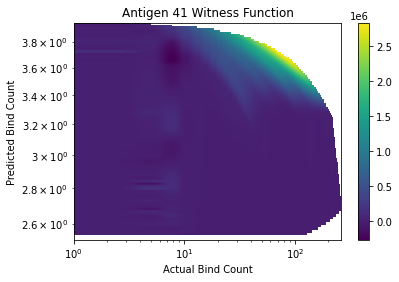

In [13]:
plot_witness_surface(41)

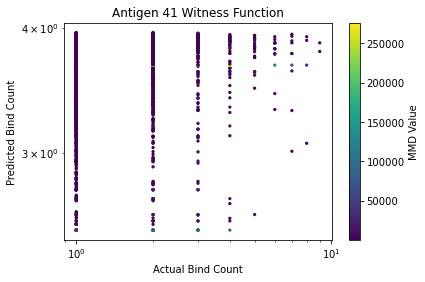

In [14]:
def plot_witness(col, n_samples=sys.maxsize):
    Z = f(y_hat_mtx[:n_samples, col], y_mtx[:n_samples, col])
    # plt.hist(Z[:n_samples].cpu(), bins=100, log=True)
    X = y_mtx[:n_samples, col]
    Y = y_hat_mtx[:n_samples, col]

    graph = np.column_stack((X, np.exp(Y), Z.cpu()))
    sorted_idcs = np.lexsort((graph[:,2], graph[:,1]))
    graph = graph[sorted_idcs]
    graph = graph[graph[:, 0] < 10]

    # Using scatter plot for MMD values
    plt.scatter(graph[:, 0], graph[:, 1], c=graph[:, 2], cmap='viridis', s=5)
    plt.colorbar(label="MMD Value")  # Add a colorbar to indicate MMD values
    plt.title(f"Antigen {col} Witness Function")
    plt.xlabel("Actual Bind Count")
    plt.ylabel("Predicted Bind Count")
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.show()
plot_witness(41, n_samples=sys.maxsize)

(array([  3., 468.,  94.,  42.,  29.,   4.,  19.,   3.,  30.,  26.,   1.,
          7.,   1.,   7.,   5.,   0., 132.,   5.,  18.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,  29.,   0.,   0.,  11.,
          0.,   0.,   7.,  15.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,
          0.,   0.,  22.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   58.04119492,  116.08238983,  174.12359619,
         232.16477966,  290.20599365,  348.24719238,  406.2883606 ,
         464.32955933,  522.37078857,  580.4119873 ,  638.45318604,
         696.49438477,  754.53552246,  812.57672119,  870.61791992,
         928.65911865,  986.70031738, 1044.741

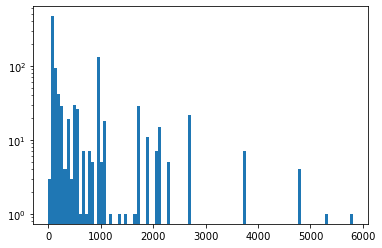

In [15]:
plt.hist(f(y_hat_mtx[:1000, 41], y_mtx[:1000, 41]).cpu(), log=True, bins=100)

## Permutation test

In [17]:
import numpy as np

def permutation_test(matrix1, matrix2, n_perms=1000):
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape")
    
    n, c = matrix1.shape
    observed_statistic = mmd_pois(matrix1, matrix2).cpu().numpy()  # Convert to numpy
    num_extreme_values = np.zeros(c)

    reshuffled_indices = np.arange(2 * n)  # indices for both matrices concatenated

    for _ in range(n_perms):
        np.random.shuffle(reshuffled_indices)
        
        permuted_matrix1 = np.vstack([matrix1, matrix2])[reshuffled_indices[:n]]
        permuted_matrix2 = np.vstack([matrix1, matrix2])[reshuffled_indices[n:]]
            
        permuted_statistic = mmd_pois(permuted_matrix1, permuted_matrix2).cpu().numpy()  # Convert to numpy
        num_extreme_values += (np.abs(permuted_statistic) >= np.abs(observed_statistic)).astype(int)
                
    p_value = num_extreme_values / n_perms

    return p_value, observed_statistic

# assuming y_hat_mtx and y_mtx are already defined
p_value, observed_statistic = permutation_test(y_hat_mtx, y_mtx, n_perms=50)
print(f"Observed Statistic: {observed_statistic}")
print(f"P-value: {p_value}")

Observed Statistic: [0.17342234 0.17785706 0.13135868 0.19199657 0.17198086 0.18195924
 0.18001401 0.16263488 0.18606561 0.1353484  0.19548526 0.19669414
 0.17318623 0.1240429  0.08301401 0.09463717 0.1671572  0.17936185
 0.17585236 0.15030895 0.18404491 0.17731711 0.17000778 0.17401771
 0.19247498 0.17836551 0.17335482 0.17130299 0.16496937 0.09227274
 0.07628852 0.11465546 0.08943316 0.091553   0.16642806 0.15696041
 0.16386046 0.15801544 0.16517033 0.15261284 0.17339687 0.09055868
 0.1538231  0.13309442 0.1708532  0.16201267 0.17407733 0.13879217
 0.15859476 0.1624651 ]
P-value: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.84 0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   1.   1.   0.26 0.94 0.96 0.   0.   0.   0.   0.   0.   0.   0.96
 0.   0.   0.   0.   0.   0.   0.   0.  ]


### Calculate p-value (U-statistic)

In [21]:
def bootstrap_mat(mat, b=100):
    """FROM THE PAPER
    Algorithm 1 Bootstrap Goodness-of-fit Test based on KSD
        Input: Sample {xi } and score function sq (x) = ∇x log q(x). Bootstrap sample size m.
        Test: H0: {xi} is drawn from q v.s H1: {xi} is not drawn from q.
        1. Compute Sˆu by (14) and uq(x,x′) as defined in The- orem 3.6. Generate m bootstrap sample Sˆ∗u by (16).
        2. Reject H0 with significance level α if the percentage of Sˆ∗u that satisfies Sˆ∗u > Sˆu is less than α.
    """
    """We bootstrap the degenerate U statistic assuming identical p, q.
    We can't use a usual bootstrap (wo -1/N) as dicussed in Arcones & Gine 1992:
    We want to perform the bootstrap on the first non-zero term in the Hoeffding decomposition,
    which in this case is the same U-stat with h(x, y) made degenerate. This sum will stay
    O(1/N) while the actual U-stat is O(1/sqrt(N))."""
    N = len(mat)
    mat = mat.cpu().numpy()
    ws = np.random.multinomial(N, np.ones(N)/N, b)
    mats = np.einsum('ij,bi,bj->bij', mat, (ws-1)/N, (ws-1)/N)
    return [ma.masked_array(mat_i, np.eye(len(mat))).sum() for mat_i in mats]

In [22]:
ANTIGEN = 14
mu = tc.Tensor(ffn.predictions).to(device)
y_mtx = tc.Tensor(ffn.y_test).to(device)
C = c(mu[:, None, ANTIGEN], mu[None, :, ANTIGEN])
residual = y_mtx - mu
K = k(residual[:, None, ANTIGEN], residual[None, :, ANTIGEN])
print(C.shape, K.shape)
M = C * K

torch.Size([5815, 5815]) torch.Size([5815, 5815])


In [23]:
# repeat identity mask for all dimensions
# mask = np.repeat(np.eye(M.shape[-1])[np.newaxis, :, :], M.shape[0], axis=0)
u_stat = ma.masked_array(M.cpu(), np.eye(*M.shape)).mean()
p_value = np.mean(u_stat > bootstrap_mat(M))
p_value

0.0